<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import numpy as np
import pandas as pd

In [170]:
# Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L = 1.5  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 3  # устьевого штуцера
r_GU = 3  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
h_0 = 2000  # номинальный напор
q_0 = 70  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]
lambda_2 = [0.5, 0.82, 0.74]
lambda_3 = [0.42, 0.18, 0.3]

In [171]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []

In [172]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_R

0.09999999999999999

In [173]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [174]:
# Высота столба жидкости

dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [175]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = k_S*X_G*M_R3

In [176]:
# Расчёт динамики

# Начальные условия
epsilon = 0.02 * q_0
M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 0

# Сегмент напорной характеристики
i = 1

In [177]:
# Начало расчёта
for k in range(35000):

    p_3 = p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q + gamma * h_4
    p_3 = p_3 / (1 + r_GU * np.sqrt(w) * a_GU* q)

    _q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)

    # Балансировка притока по начальным условиям
    while abs(_q - q) > epsilon:
      q = (1 - M_q)*q + M_q *_q

      p_3 = p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q + gamma * h_4
      p_3 = p_3 / (1 + r_GU * np.sqrt(w) * a_GU* q)

      _q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)

    q = _q

    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
    q_N = max(q_N, 0)

    while q_N > w*q_0*q_Pump[i]:
        i-=1
        i = max(i, 0)
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)

    while q_N < w*q_0*q_Pump[i]:
        i+=1
        i = min(i, 2)
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)



    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_R3*(p_G0 - p_3))
    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))

    h_4 = (1/gamma)*(p_3 - p_L - r_GU*np.sqrt(w)*a_GU*(p_G0-p_3)*q)

    p_1 = p_R - r_R*q

    _p_1.append(p_1)
    _p_3.append(p_3)
    _q_N.append(q_N)
    __q.append(q)
    _h_4.append(h_4)
    _u.append(w)

    # Шаг по Эйлеру

    p_2 = p_2 + (0.0001/0.4)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (0.0001/0.01)*(q-q_N)

    if k == 3000:
      w = 0
    if k == 5000:
      w = 1

    if h_4 < 101:
      w = 0



In [178]:
x = [0.0001*k for k in range(35000)]

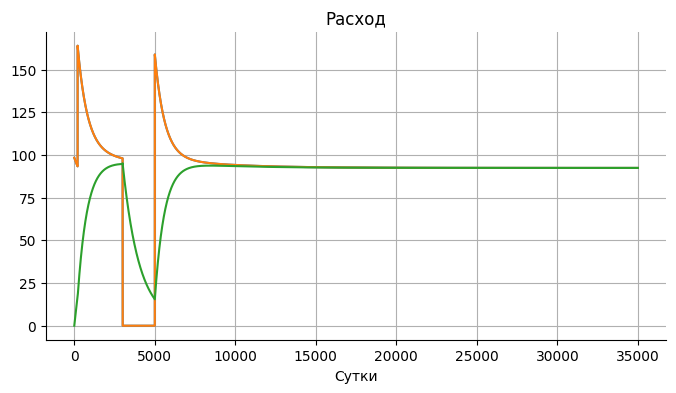

In [179]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u})

from matplotlib import pyplot as plt
df['q_N'].plot(kind='line', figsize=(8, 4), title='q_N', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

x = np.linspace(0, 3,5, 3499)

# plot one by one
plt.plot(df['q_N'])
plt.plot(df['q'])


# set x label
plt.xlabel('Сутки')

# set title
plt.title('Расход')

# display plot
plt.show()

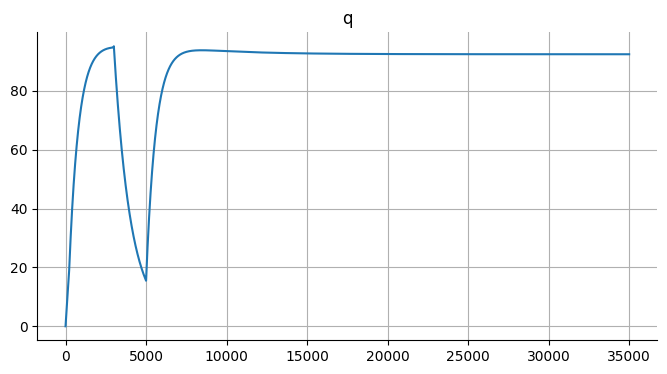

In [180]:
from matplotlib import pyplot as plt
df['q'].plot(kind='line', figsize=(8, 4), title='q', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

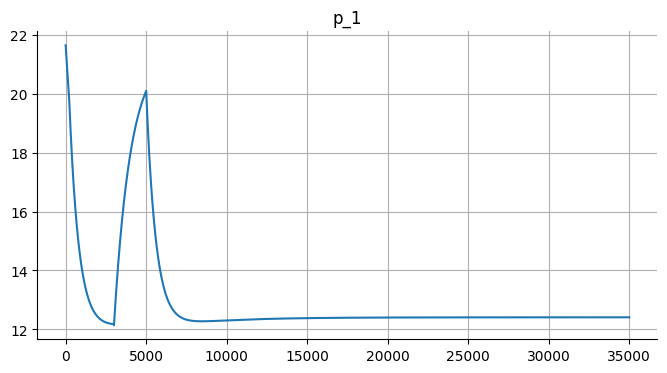

In [181]:
from matplotlib import pyplot as plt
df['p_1'].plot(kind='line', figsize=(8, 4), title='p_1', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

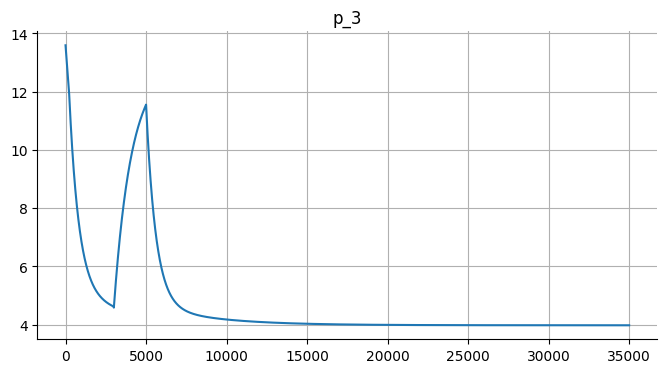

In [182]:
from matplotlib import pyplot as plt
df['p_3'].plot(kind='line', figsize=(8, 4), title='p_3', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

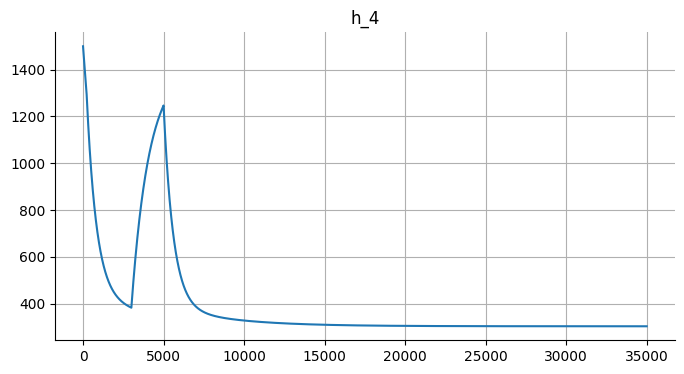

In [183]:
from matplotlib import pyplot as plt
df['h_4'].plot(kind='line', figsize=(8, 4), title='h_4', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

In [184]:
df.iloc[10200]

,10200
q_N,94.066406
p_3,4.162764
p_1,12.307362
q,93.426385
h_4,326.201604
u,1.000000


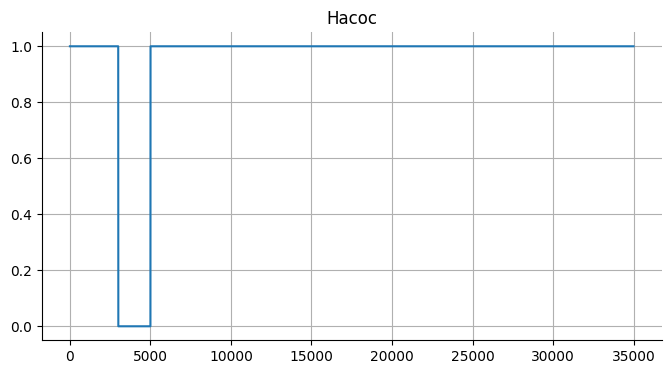

In [185]:
from matplotlib import pyplot as plt
df['u'].plot(kind='line', figsize=(8, 4), title='Насос', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

In [186]:
h_4

302.96457745297204